In [1]:
import tensorflow as tf
from utils import *
from tf_utils import *
from collections import Counter
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#### Load RNAseqDB data

In [2]:
# Load dataset
expr_df, info_df = rnaseqdb_load()
x = expr_df.values.T
symbols = expr_df.index.levels[0].values
sampl_ids = expr_df.columns.values
tissues = info_df['TISSUE_GTEX'].values
datasets = info_df['DATASET'].values

# Log-transform data
x = np.log(1 + x)
x = np.float32(x)

# Process categorical metadata
cat_dicts = []
tissues_dict_inv = np.array(list(sorted(set(tissues))))
tissues_dict = {t: i for i, t in enumerate(tissues_dict_inv)}
tissues = np.vectorize(lambda t: tissues_dict[t])(tissues)
cat_dicts.append(tissues_dict_inv)
dataset_dict_inv = np.array(list(sorted(set(datasets))))
dataset_dict = {d: i for i, d in enumerate(dataset_dict_inv)}
datasets = np.vectorize(lambda t: dataset_dict[t])(datasets)
cat_dicts.append(dataset_dict_inv)
cat_covs = np.concatenate((tissues[:, None], datasets[:, None]), axis=-1)
cat_covs = np.int32(cat_covs)
print('Cat covs: ', cat_covs.shape)

# Process numerical metadata
num_covs = np.zeros((x.shape[0], 1), dtype=np.float32)
print('Num covs: ', num_covs.shape)

# Train/test split
np.random.seed(0)
idx = np.arange(x.shape[0])
np.random.shuffle(idx)
x = x[idx, :]
num_covs = num_covs[idx, :]
cat_covs = cat_covs[idx, :]

x_train, x_test = split_train_test(x)
num_covs_train, num_covs_test = split_train_test(num_covs)
cat_covs_train, cat_covs_test = split_train_test(cat_covs)

# Normalise data
x_mean = np.mean(x_train, axis=0)
x_std = np.std(x_train, axis=0)
# x_train = standardize(x_train, mean=x_mean, std=x_std)
# x_test = standardize(x_test, mean=x_mean, std=x_std)

... loading RNASeqDB dataset
Cat covs:  (9147, 2)
Num covs:  (9147, 1)


#### Load trained generator

In [3]:
# GPU limit
limit_gpu(3)
gen = tf.keras.models.load_model('/local/scratch/rv340/checkpoints/models/gen_rnaseqdb.h5')

#### UMAP plot of synthetic data

In [4]:
x_gen = predict(cc=cat_covs_test,
                nc=num_covs_test,
                gen=gen)
x_gen = x_gen*x_std + x_mean
x_gen = np.clip(x_gen, 0, a_max=None)

In [5]:
x_combined = np.concatenate((x_test, x_gen))
categories = ['real'] * x_test.shape[0] + ['fake'] * x_gen.shape[0]
tissues_test = [tissues_dict_inv[tidx] for tidx in cat_covs_test[:, 0]]
tissues_combined = tissues_test + tissues_test

emb_2d = umap.UMAP().fit_transform(x_combined)

/home/rv340/anaconda3/envs/pytorch38/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


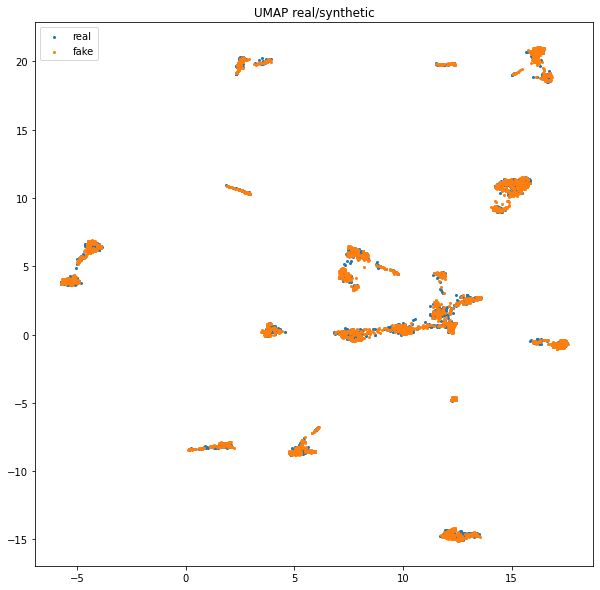

In [6]:
plt.figure(figsize=(10, 10))
plot_tsne_2d(emb_2d, labels=np.array(categories), s=4)
plt.title('UMAP real/synthetic');

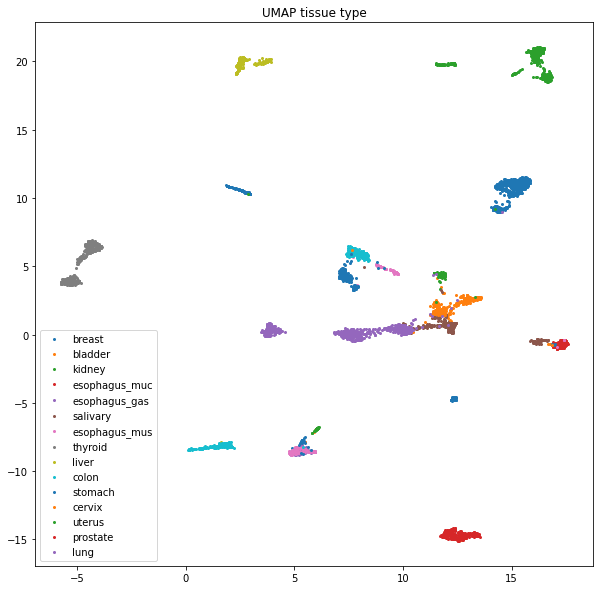

In [7]:
plt.figure(figsize=(10, 10))
plot_tsne_2d(emb_2d, labels=np.array(tissues_combined), s=4)
plt.title('UMAP tissue type');

#### UMAP plot for breast data

In [8]:
breast_idxs = np.argwhere(cat_covs[:, 0] == 1).ravel()
x_breast = x[breast_idxs]  # standardize(x[breast_idxs], mean=x_mean, std=x_std)
num_covs_ = np.concatenate((num_covs_train, num_covs_test), axis=0)
num_covs_breast = num_covs_[breast_idxs]
cat_covs_breast = cat_covs[breast_idxs]
len(breast_idxs)

1181

In [9]:
x_breast_gen = predict(cc=cat_covs_breast,
                nc=num_covs_breast,
                gen=gen)
x_breast_gen = x_breast_gen*x_std + x_mean

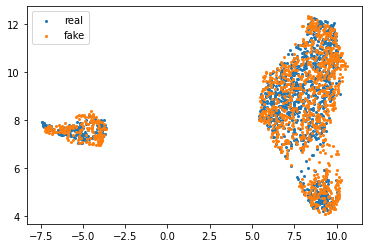

In [10]:
x_breast_comb = np.concatenate((x_breast, x_breast_gen))
emb_2d = umap.UMAP().fit_transform(x_breast_comb)
categories = ['real'] * x_breast.shape[0] + ['fake'] * x_breast_gen.shape[0]
plot_tsne_2d(emb_2d, labels=np.array(categories), s=4);

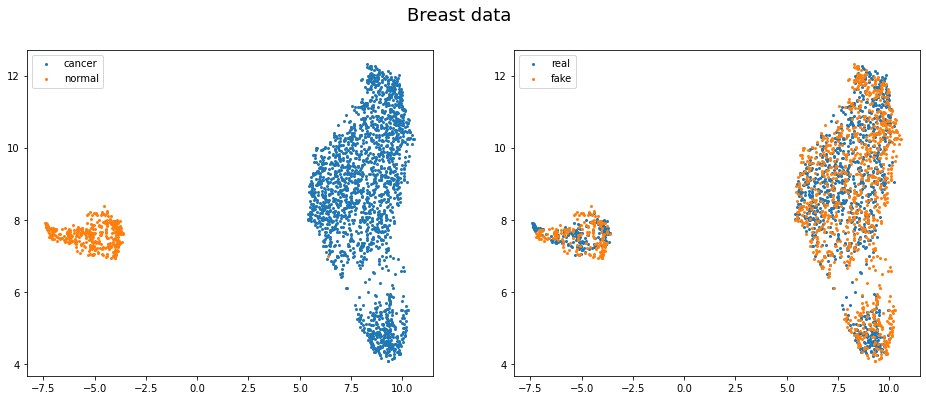

In [11]:
plt.figure(figsize=(16, 6))
real_fake = ['real'] * x_breast.shape[0] + ['fake'] * x_breast_gen.shape[0]
normal_cancer = ['cancer' if d == 2 else 'normal' for d in cat_covs_breast[:, 1]] * 2
plt.subplot(1, 2, 1)
plot_tsne_2d(emb_2d, labels=np.array(normal_cancer), s=4);
plt.subplot(1, 2, 2)
plot_tsne_2d(emb_2d, labels=np.array(real_fake), s=4)
plt.suptitle('Breast data', fontsize=18);

#### Store data

In [12]:
np.savetxt("data/human/train.csv", x_train, delimiter=",", header=",".join(symbols))
np.savetxt("data/human/test.csv", x_test, delimiter=",", header=",".join(symbols))
np.savetxt("data/human/gen.csv", x_gen, delimiter=",", header=",".join(symbols))